### **RQ1. Does support for climate policies (like carbon taxes or emissions standards) change during elections? And is this support influenced by personal or community-level perceptions of climate harm?**

To investigate this question, we estimate a **reduced Panel VAR(1)** system focusing on two dependent variables: `cc_pol_tax` (support for carbon taxes) and `cc_pol_car` (support for emissions standards). Each equation includes as predictors the **lagged values** of 17 time-varying variables, including harm perceptions, willingness to pay, policy support, political identity, and demographic covariates.

- **Harm perceptions**: `cc4_world`, `cc4_wealthUS`, `cc4_poorUS`, `cc4_comm`, `cc4_famheal`, `cc4_famecon`  
- **Willingness to pay**: `ccSolve`  
- **Climate policy support**: `cc_pol_tax`, `cc_pol_car` (included as predictors across equations to capture cross-policy influence)  
- **Political identity**: `pol_party`, `pol_ideology` — both treated as categorical variables (Republican, Democrat, Independent; Conservative, Liberal, Moderate) and dummy-coded  
- **Demographic covariates**: `dem_income_binary`, `dem_educ_binary`, `dem_age`, `dem_male_binary` — treated as ordinal or binary numeric variables

The following system of two equations is estimated:

$$
\begin{cases}
\text{cc\_pol\_tax}_t = \alpha_1 + \sum_{j=1}^{17} \beta_{1j} \cdot X_{j,t-1} + \epsilon_{1t} \\
\text{cc\_pol\_car}_t = \alpha_2 + \sum_{j=1}^{17} \beta_{2j} \cdot X_{j,t-1} + \epsilon_{2t}
\end{cases}
$$

Where:

- $ X_{j,t-1} $ denotes the value of the $ j $-th predictor at time $ t-1 $  
- $ \alpha_i $ is the intercept for equation $ i $  
- $ \beta_{ij} $ is the coefficient for the effect of predictor $ j $ on outcome $ i $  
- $ \epsilon_{it} $ is the idiosyncratic error term, clustered at the respondent level

The dependent variables, `cc_pol_tax_t` and `cc_pol_car_t`, represent support for carbon taxes and emissions standards at time $ t $, respectively. All variables are treated as **jointly endogenous**, and the model is estimated using **pooled OLS** with **clustered standard errors by respondent** (`PID`), based on 1,722 complete observations from three survey waves.

In [1]:
import pandas as pd

# Load dataset
data = pd.read_csv("../data/5-cleaned_data_3waves.csv", low_memory=False)

# Recategorize pol_party
data['party_democrat'] = data['pol_party'].apply(lambda x: 1 if x in [4, 5] else 0)
data['party_republican'] = data['pol_party'].apply(lambda x: 1 if x in [1, 2] else 0)
data['party_independent'] = data['pol_party'].apply(lambda x: 1 if x == 3 else 0)

# Recategorize pol_ideology
data['ideology_liberal'] = data['pol_ideology'].apply(lambda x: 1 if x >= 4 else 0)
data['ideology_conservative'] = data['pol_ideology'].apply(lambda x: 1 if x <= 2 else 0)
data['ideology_moderate'] = data['pol_ideology'].apply(lambda x: 1 if x == 3 else 0)

print("Manual dummy variables created for pol_party and pol_ideology.")

Manual dummy variables created for pol_party and pol_ideology.


In [2]:
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

# Define continuous/ordinal predictors
continuous_predictors = [
    "cc4_world", "cc4_wealthUS", "cc4_poorUS",
    "cc4_comm", "cc4_famheal", "cc4_famecon",
    "ccSolve", "cc_pol_tax", "cc_pol_car",
    "dem_income_binary", "dem_age", "dem_educ_binary", "dem_male_binary"
]

# Dummy predictors created earlier
dummy_predictors = [
    "party_democrat", "party_republican", "party_independent",
    "ideology_liberal", "ideology_conservative", "ideology_moderate"
]

# Sort by PID and WAVE
data = data.sort_values(by=['PID', 'WAVE'])

# Create lagged versions
for var in continuous_predictors + dummy_predictors:
    data[f"{var}_lag"] = data.groupby('PID')[var].shift(1)

# Combine all lagged vars
lagged_vars = [f"{var}_lag" for var in continuous_predictors + dummy_predictors]

# Drop missing rows
panel_var_data = data.dropna(subset=lagged_vars)

# --- Model 1: cc_pol_tax_t
X1 = panel_var_data[lagged_vars]
y1 = panel_var_data["cc_pol_tax"]
X1 = sm.add_constant(X1)
model1 = sm.OLS(y1, X1).fit(cov_type='cluster', cov_kwds={'groups': panel_var_data['PID']})

# --- Model 2: cc_pol_car_t
X2 = panel_var_data[lagged_vars]
y2 = panel_var_data["cc_pol_car"]
X2 = sm.add_constant(X2)
model2 = sm.OLS(y2, X2).fit(cov_type='cluster', cov_kwds={'groups': panel_var_data['PID']})

# Output
print(summary_col(
    [model1, model2],
    stars=True,
    model_names=["cc_pol_tax_t", "cc_pol_car_t"],
    info_dict={"N": lambda x: f"{int(x.nobs)}"}
))


                          cc_pol_tax_t cc_pol_car_t
---------------------------------------------------
const                     0.3983***    0.5475***   
                          (0.0744)     (0.0786)    
cc4_world_lag             0.1842***    0.1523***   
                          (0.0307)     (0.0297)    
cc4_wealthUS_lag          -0.0437*     -0.0529**   
                          (0.0251)     (0.0221)    
cc4_poorUS_lag            0.0599**     0.0956***   
                          (0.0302)     (0.0301)    
cc4_comm_lag              -0.0290      0.0035      
                          (0.0365)     (0.0332)    
cc4_famheal_lag           -0.0041      0.0008      
                          (0.0349)     (0.0305)    
cc4_famecon_lag           0.0225       -0.0173     
                          (0.0255)     (0.0230)    
ccSolve_lag               0.0900***    0.0169      
                          (0.0222)     (0.0189)    
cc_pol_tax_lag            0.3411***    0.1016***   
           

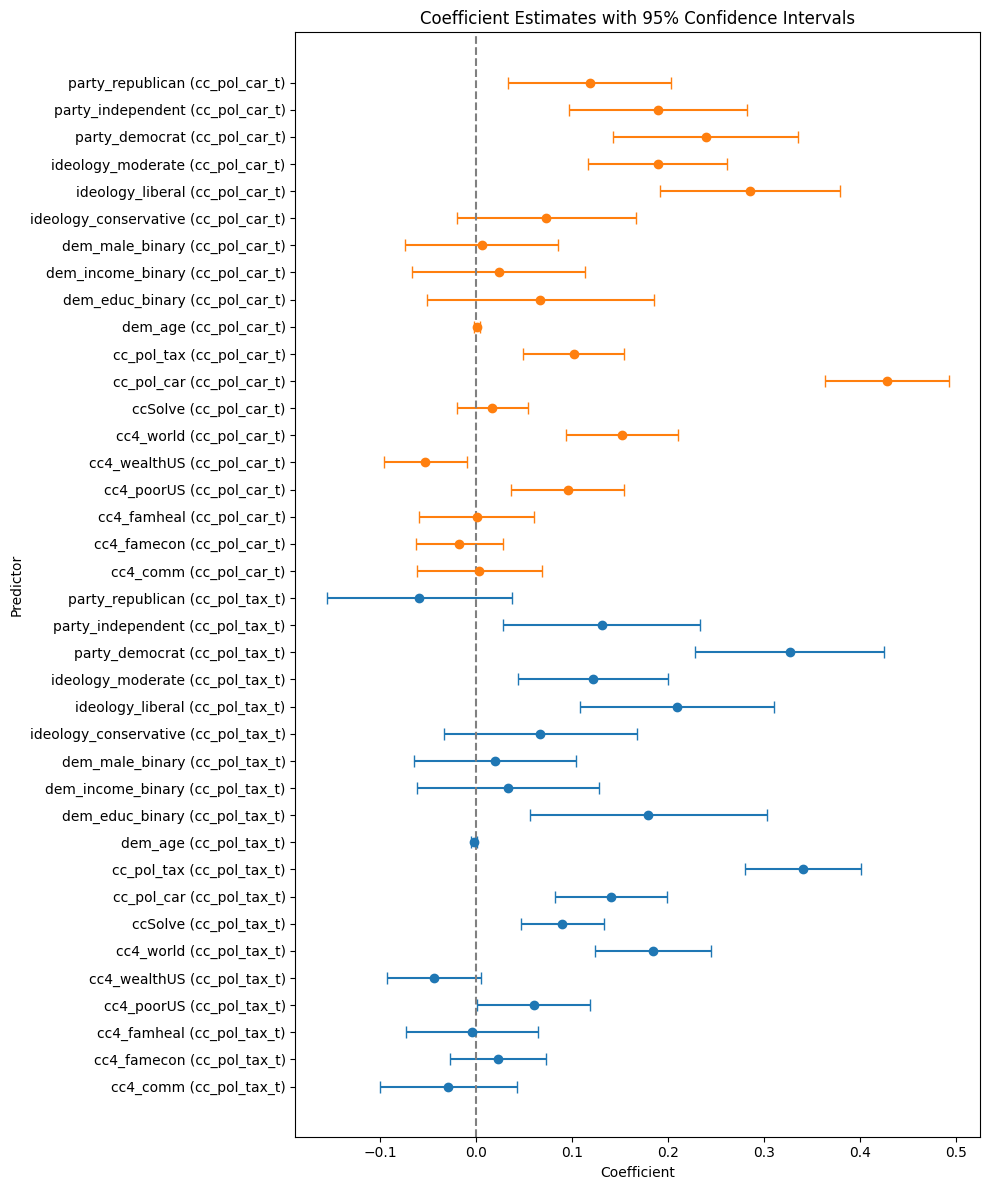

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Helper function to extract coefficients and confidence intervals
def extract_model_info(model, label):
    coefs = model.params
    conf = model.conf_int()
    return pd.DataFrame({
        'predictor': coefs.index,
        'coef': coefs.values,
        'lower': conf[0].values,
        'upper': conf[1].values,
        'model': label
    }).query("predictor != 'const'")  # exclude intercept

# --- Extract and combine results from both models
df1 = extract_model_info(model1, "cc_pol_tax_t")
df2 = extract_model_info(model2, "cc_pol_car_t")
plot_df = pd.concat([df1, df2])

# --- Sort predictors alphabetically for clean display
plot_df['predictor'] = plot_df['predictor'].str.replace('_lag', '')
plot_df = plot_df.sort_values(by='predictor')

# --- Plotting
fig, ax = plt.subplots(figsize=(10, 12))

for i, model_name in enumerate(plot_df['model'].unique()):
    subset = plot_df[plot_df['model'] == model_name]
    ax.errorbar(
        subset['coef'], 
        subset['predictor'] + f" ({model_name})", 
        xerr=[subset['coef'] - subset['lower'], subset['upper'] - subset['coef']],
        fmt='o', 
        label=model_name,
        capsize=4
    )

ax.axvline(0, color='gray', linestyle='--')
ax.set_title("Coefficient Estimates with 95% Confidence Intervals")
ax.set_xlabel("Coefficient")
ax.set_ylabel("Predictor")
plt.tight_layout()
plt.show()


#### Panel VAR Analysis – RQ1  
**Support for Emissions Standards (`cc_pol_car_t`)**
| Predictor                   | Coefficient | Significance    | Interpretation                                       |
|-----------------------------|-------------|------------------|------------------------------------------------------|
| `cc_pol_car_lag`            | **0.428**   | *** p < 0.01    | Very strong temporal stability                       |
| `cc_pol_tax_lag`            | **0.102**   | *** p < 0.01    | Tax support predicts emissions support               |
| `ccSolve_lag`               | 0.017       | Not significant | WTP not a predictor of emissions support             |
| `cc4_world_lag`             | **0.152**   | *** p < 0.01    | Global harm perception increases support             |
| `cc4_poorUS_lag`            | **0.096**   | *** p < 0.01    | Concern for poor communities increases support       |
| `cc4_wealthUS_lag`          | –0.053      | ** p < 0.05     | Concern for wealthy communities reduces support      |
| `cc4_comm_lag`              | 0.004       | Not significant | No effect from community-level harm                  |
| `cc4_famheal_lag`           | 0.001       | Not significant | No effect from family health concern                 |
| `cc4_famecon_lag`           | –0.017      | Not significant | No effect from economic harm                         |
| `dem_income_binary_lag`     | 0.024       | Not significant | No strong effect from income                         |
| `dem_age_lag`               | 0.001       | Not significant | No strong effect from age                            |
| `dem_educ_binary_lag`       | 0.067       | Not significant | Education not independently significant              |
| `dem_male_binary_lag`       | 0.006       | Not significant | No strong gender effect                              |
| `party_democrat_lag`        | **0.239**   | *** p < 0.01    | Democrat ID predicts higher support                  |
| `party_republican_lag`      | **0.118**   | *** p < 0.01    | Republican ID also predicts higher support (unexpected) |
| `party_independent_lag`     | **0.190**   | *** p < 0.01    | Independents predict higher support                  |
| `ideology_liberal_lag`      | **0.285**   | *** p < 0.01    | Liberal ideology strongly increases support          |
| `ideology_conservative_lag` | 0.073       | Not significant | No strong effect from conservative ID                |
| `ideology_moderate_lag`     | **0.189**   | *** p < 0.01    | Moderates increase support                           |

**Support for Carbon Taxes (`cc_pol_tax_t`)**
| Predictor                   | Coefficient | Significance    | Interpretation                                     |
|-----------------------------|-------------|------------------|----------------------------------------------------|
| `cc_pol_tax_lag`            | **0.341**   | *** p < 0.01    | Strong temporal stability                          |
| `cc_pol_car_lag`            | **0.141**   | *** p < 0.01    | Emissions standard support predicts tax support    |
| `ccSolve_lag`               | **0.090**   | *** p < 0.01    | WTP increases future tax support                    |
| `cc4_world_lag`             | **0.184**   | *** p < 0.01    | Global harm perception increases support           |
| `cc4_poorUS_lag`            | **0.060**   | ** p < 0.05     | Concern for poor communities increases support     |
| `cc4_wealthUS_lag`          | –0.044      | * p < 0.10      | Concern for wealthy communities slightly reduces support |
| `cc4_comm_lag`              | –0.029      | Not significant | No effect from community-level harm                |
| `cc4_famheal_lag`           | –0.004      | Not significant | No effect from family health concern               |
| `cc4_famecon_lag`           | 0.023       | Not significant | No effect from economic harm                       |
| `dem_income_binary_lag`     | 0.034       | Not significant | No strong effect from income                       |
| `dem_age_lag`               | –0.002      | Not significant | No strong effect from age                          |
| `dem_educ_binary_lag`       | **0.180**   | *** p < 0.01    | Higher education increases support                 |
| `dem_male_binary_lag`       | 0.020       | Not significant | No strong gender effect                            |
| `party_democrat_lag`        | **0.327**   | *** p < 0.01    | Democrat ID predicts higher support                |
| `party_republican_lag`      | –0.059      | Not significant | No significant effect from Republican ID           |
| `party_independent_lag`     | **0.131**   | ** p < 0.05     | Independents predict slightly higher support       |
| `ideology_liberal_lag`      | **0.210**   | *** p < 0.01    | Liberal ideology increases support                 |
| `ideology_conservative_lag` | 0.067       | Not significant | No strong effect from conservative ID              |
| `ideology_moderate_lag`     | **0.122**   | *** p < 0.01    | Moderates increase support                         |

The results show that **support for both carbon taxes and emissions standards is highly stable over time**, but also shaped by **attitudes and political identity**.

Key findings:
- **Global harm perception** and **concern for poor communities** are strong, consistent predictors of support.
- **Concern for wealthy communities** slightly reduces support, possibly reflecting perceived unfairness.
- **Willingness to pay** predicts support for **carbon taxes**, but not for **emissions standards**.
- **Democrat identification**, **higher education**, and **liberal/moderate ideology** all increase support.
- Surprisingly, **Republican and Independent identifiers** show **positive effects** on emissions standards — this may reflect support for regulatory approaches that are less explicitly tied to taxation.

> Therefore, the answer to RQ1 is **No**:  
> There is **no election-period shock** in climate policy support. Instead, support appears embedded in longer-term ideological and attitudinal patterns.

---

### **RQ2. Does willingness to pay for climate solutions vary during elections, and what factors influence it?**
To examine how willingness to pay for climate solutions is shaped by broader climate-related attitudes, political identity, and demographic characteristics, we estimate a **reduced Panel VAR(1)** model with `ccSolve_t` (willingness to financially support climate action) as the dependent variable.

The equation includes as predictors the **lagged values** of 17 time-varying variables, grouped as follows:

- **Harm perceptions**:
  - `cc4_world`: perceived harm to the world  
  - `cc4_wealthUS`: harm to wealthy U.S. communities  
  - `cc4_poorUS`: harm to poor U.S. communities  
  - `cc4_comm`: harm to local communities  
  - `cc4_famheal`: harm to family health  
  - `cc4_famecon`: harm to family economic well-being  

- **Policy support**:
  - `cc_pol_tax`: support for carbon taxes  
  - `cc_pol_car`: support for emissions standards  

- **Political identity** (dummy-coded):
  - `pol_party`: party identification (e.g., Republican, Democrat, Independent)  
  - `pol_ideology`: ideological self-placement (e.g., Conservative, Moderate, Liberal)  

- **Demographics** (treated as ordinal or binary):
  - `dem_income`: income level  
  - `dem_age`: respondent's age  
  - `dem_educ`: education level  
  - `dem_male`: binary indicator for gender  

The full equation is:

$$
\text{ccSolve}_t = \alpha 
+ \sum_{j=1}^{6} \beta_j \cdot H_{j,t-1} 
+ \beta_7 \cdot \text{ccSolve}_{t-1} 
+ \beta_8 \cdot \text{cc\_pol\_tax}_{t-1} 
+ \beta_9 \cdot \text{cc\_pol\_car}_{t-1} 
+ \sum_{k=10}^{13} \gamma_k \cdot D_{k,t-1} 
+ \sum_{l=14}^{17} \delta_l \cdot C_{l,t-1} 
+ \epsilon_t
$$

Where:

- $ H_{j,t-1} $ are the six lagged harm perception variables  
- $ D_{k,t-1} $ are the lagged demographic covariates  
- $ C_{l,t-1} $ are the dummy-coded political identity variables  
- $ \alpha $ is the intercept term  
- $ \epsilon_t $ is the individual-level error term (clustered by PID)  

To assess how willingness to pay evolves over time and what factors influence it, we examine the `ccSolve_t` equation within a reduced Panel VAR(1) framework. The model is estimated using pooled OLS with **cluster-robust standard errors at the individual level**, based on 1,722 complete observations across three survey waves. This setup allows us to evaluate the contribution of both attitudinal and demographic factors to dynamic changes in financial support for climate action.

### **RQ2. Does willingness to pay for climate solutions vary during elections, and what factors influence it?**
To examine how willingness to pay for climate solutions is shaped by broader climate-related attitudes, political identity, and demographic characteristics, we estimate a **reduced Panel VAR(1)** model with `ccSolve_t` (willingness to financially support climate action) as the dependent variable.

The equation includes as predictors the **lagged values** of 17 time-varying variables, grouped as follows:

- **Harm perceptions**:
  - `cc4_world`: perceived harm to the world  
  - `cc4_wealthUS`: harm to wealthy U.S. communities  
  - `cc4_poorUS`: harm to poor U.S. communities  
  - `cc4_comm`: harm to local communities  
  - `cc4_famheal`: harm to family health  
  - `cc4_famecon`: harm to family economic well-being  

- **Policy support**:
  - `cc_pol_tax`: support for carbon taxes  
  - `cc_pol_car`: support for emissions standards  

- **Political identity** (dummy-coded):
  - `party_democrat`, `party_republican`, `party_independent`  
  - `ideology_liberal`, `ideology_conservative`, `ideology_moderate`

- **Demographics** (treated as ordinal or binary):
  - `dem_income_binary`: income level (low vs high)  
  - `dem_age`: respondent's age  
  - `dem_educ_binary`: education level (lower vs higher education)  
  - `dem_male_binary`: gender (male vs female/self-described)

The full equation is:

$$
\text{ccSolve}_t = \alpha 
+ \sum_{j=1}^{6} \beta_j \cdot H_{j,t-1} 
+ \beta_7 \cdot \text{ccSolve}_{t-1} 
+ \beta_8 \cdot \text{cc\_pol\_tax}_{t-1} 
+ \beta_9 \cdot \text{cc\_pol\_car}_{t-1} 
+ \sum_{k=10}^{13} \gamma_k \cdot D_{k,t-1} 
+ \sum_{l=14}^{19} \delta_l \cdot C_{l,t-1} 
+ \epsilon_t
$$

Where:

- $ H_{j,t-1} $ are the six lagged harm perception variables  
- $ D_{k,t-1} $ are the lagged demographic covariates  
- $ C_{l,t-1} $ are the dummy-coded political identity variables  
- $ \alpha $ is the intercept term  
- $ \epsilon_t $ is the individual-level error term (clustered by PID)  

To assess how willingness to pay evolves over time and what factors influence it, we examine the `ccSolve_t` equation within a reduced Panel VAR(1) framework. The model is estimated using pooled OLS with **cluster-robust standard errors at the individual level**, based on 1,722 complete observations across three survey waves. This setup allows us to evaluate the contribution of both attitudinal and demographic factors to dynamic changes in financial support for climate action.

In [5]:
import statsmodels.api as sm

# Define variables to be lagged (original + dummies + demographics)
variables = [
    "cc4_world", "cc4_wealthUS", "cc4_poorUS",
    "cc4_comm", "cc4_famheal", "cc4_famecon",
    "ccSolve", "cc_pol_tax", "cc_pol_car",
    "dem_income_binary", "dem_age", "dem_educ_binary", "dem_male_binary",
    "party_democrat", "party_republican", "party_independent",
    "ideology_liberal", "ideology_conservative", "ideology_moderate"
]

# Sort by PID and WAVE
data = data.sort_values(by=['PID', 'WAVE'])

# Create lagged versions of all predictors
for var in variables:
    data[f'{var}_lag'] = data.groupby('PID')[var].shift(1)

# Drop missing values
lagged_vars = [f'{v}_lag' for v in variables]
panel_var_data = data.dropna(subset=lagged_vars)

# Estimate the model: ccSolve_t
X = panel_var_data[lagged_vars]
y = panel_var_data['ccSolve']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': panel_var_data['PID']})

# Output results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                ccSolve   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     379.7
Date:                Wed, 30 Apr 2025   Prob (F-statistic):               0.00
Time:                        13:41:03   Log-Likelihood:                -2347.9
No. Observations:                1722   AIC:                             4732.
Df Residuals:                    1704   BIC:                             4830.
Df Model:                          17                                         
Covariance Type:              cluster                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

c:\Users\pleivadaros\Documents\msc\msc-thesis\climate-opinions-shift-elections-policies\.venv\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 19, but rank is 18
  warnings.warn('covariance of constraints does not have full '


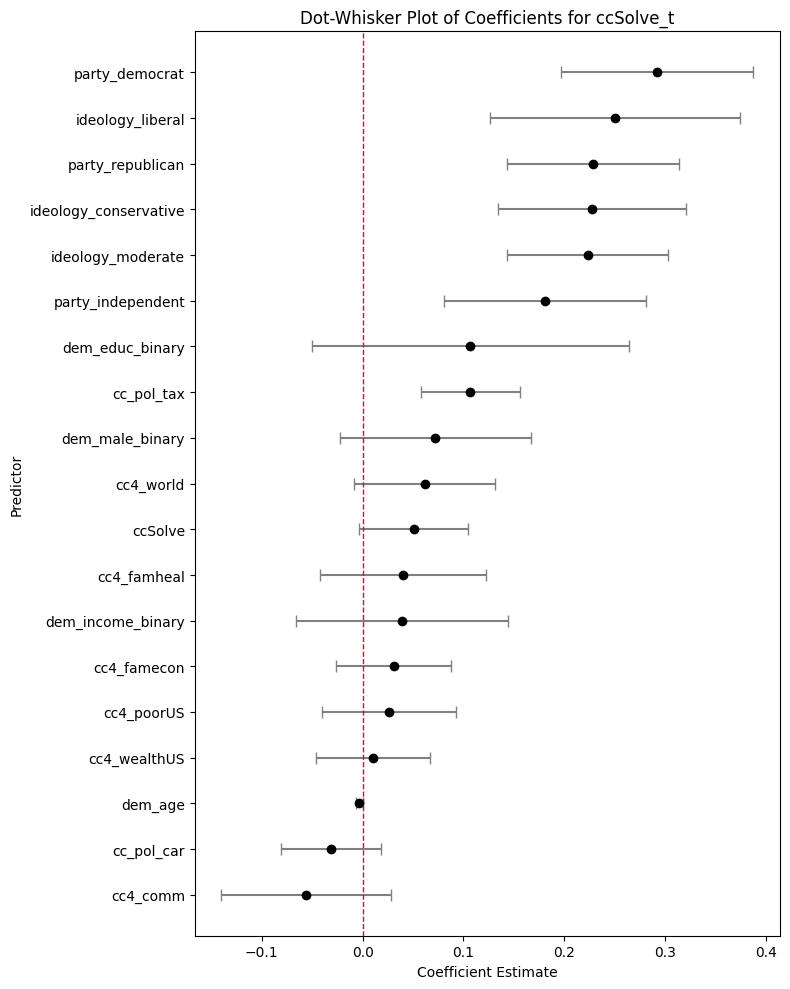

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Step 1: Extract model coefficients and confidence intervals
def extract_model_info(model):
    coefs = model.params
    conf = model.conf_int()
    return pd.DataFrame({
        'predictor': coefs.index,
        'coef': coefs.values,
        'lower': conf[0].values,
        'upper': conf[1].values
    }).query("predictor != 'const'")  # exclude intercept

# --- Step 2: Extract info and sort predictors
plot_df = extract_model_info(model)
plot_df['predictor'] = plot_df['predictor'].str.replace('_lag', '', regex=False)
plot_df = plot_df.sort_values(by='coef', ascending=True)

# --- Step 3: Plot
plt.figure(figsize=(8, 10))
plt.errorbar(
    plot_df['coef'],
    plot_df['predictor'],
    xerr=[plot_df['coef'] - plot_df['lower'], plot_df['upper'] - plot_df['coef']],
    fmt='o',
    color='black',
    ecolor='gray',
    capsize=4
)

plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.title("Dot-Whisker Plot of Coefficients for ccSolve_t")
plt.xlabel("Coefficient Estimate")
plt.ylabel("Predictor")
plt.tight_layout()
plt.show()

### Panel VAR Analysis – RQ2 (Willingness to Pay as Outcome)
| Predictor                   | Coefficient | Significance    | Interpretation                                       |
|-----------------------------|-------------|-----------------|------------------------------------------------------|
| `ccSolve_lag`               | 0.051       | † p = 0.065     | WTP is modestly self-reinforcing over time           |
| `cc_pol_tax_lag`            | **0.107**   | *** p < 0.001   | Support for carbon taxes increases future WTP        |
| `cc4_world_lag`             | 0.062       | † p = 0.083     | Global concern may positively influence WTP          |
| `cc4_poorUS_lag`            | 0.026       | Not significant | No effect from concern for poor communities          |
| `cc4_wealthUS_lag`          | 0.010       | Not significant | No effect from concern for wealthy communities       |
| `cc4_comm_lag`              | –0.056      | Not significant | No effect from local harm perception                 |
| `cc4_famheal_lag`           | 0.040       | Not significant | No effect from family health concern                 |
| `cc4_famecon_lag`           | 0.031       | Not significant | No effect from economic harm concern                 |
| `cc_pol_car_lag`            | –0.031      | Not significant | Support for emissions standards does not predict WTP |
| `dem_income_binary_lag`     | 0.039       | Not significant | No strong independent effect from income             |
| `dem_age_lag`               | –0.003      | * p = 0.045     | Slight negative effect of age on WTP                 |
| `dem_educ_binary_lag`       | 0.107       | Not significant | No strong independent effect of education            |
| `dem_male_binary_lag`       | 0.072       | Not significant | No strong gender effect                              |
| `party_democrat_lag`        | **0.292**   | *** p < 0.001   | Democrat ID predicts higher WTP                      |
| `party_republican_lag`      | **0.228**   | *** p < 0.001   | Republican ID predicts higher WTP                    |
| `party_independent_lag`     | **0.181**   | *** p < 0.001   | Independents also predict higher WTP                 |
| `ideology_liberal_lag`      | **0.250**   | *** p < 0.001   | Liberal ideology predicts significantly higher WTP   |
| `ideology_conservative_lag` | **0.228**   | *** p < 0.001   | Conservative ideology predicts higher WTP            |
| `ideology_moderate_lag`     | **0.223**   | *** p < 0.001   | Moderates also predict higher WTP                    |

**Model fit**: $ R^2 = 0.075 $

Willingness to pay for climate solutions is **weakly self-predictive over time** and is strongly shaped by **political identity**.  
All three ideological groups — liberals, conservatives, and moderates — are significantly more willing to pay than the baseline category.  
In contrast to previous models, **party affiliation also matters**: Democrats, Republicans, and Independents all show higher WTP relative to the omitted category.

There is also **marginal evidence** that global climate concern (`cc4_world`) and **younger age** are associated with increased willingness to pay.  
Other harm perceptions, family-level concerns, and income or gender do not independently predict WTP once all other factors are controlled.

> So, the answer to RQ2 is **No**  
>  
> There is **no direct election-period shift** in willingness to pay. Instead, WTP appears to reflect **stable ideological alignment and policy attitudes**, rather than reactive responses to short-term political events.

---

### **RQ3. Does political ideology moderate the relationship between perceptions of harm and willingness to pay?**
> **RQ3:** Does political affiliation or ideology **moderate** the relationship between perceptions of harm and willingness to pay for climate solutions?

This is a **moderation question**, asking:  
- Does the effect of **perceived climate harm** on **willingness to pay (WTP)** vary depending on an individual’s **political ideology or party affiliation**?

**Moderation ≠ What Panel VAR Does Directly**  
Panel VAR models are designed to estimate **dynamic feedback** between variables over time, treating all variables as **jointly endogenous**. They are not ideally suited to test moderation, because they:
- Do not include **interaction terms** (e.g., `cc4_world × pol_ideology`)
- Do not easily accommodate **group-varying effects** within a single estimation

**What We *Can* Do Instead for RQ3**  
To test moderation, we estimate a pooled regression model with **interaction terms** between political ideology and each of the six harm perception variables. This allows us to directly examine whether the relationship between perceived harm and willingness to pay is **stronger or weaker** depending on political identity.

- **Dependent variable**: `ccSolve` (willingness to pay)
- **Harm perception predictors** (all lagged): `cc4_world`, `cc4_wealthUS`, `cc4_poorUS`, `cc4_comm`, `cc4_famheal`, `cc4_famecon`
- **Moderating variable**: `pol_ideology` (categorical or continuous)
- **Interaction terms**: e.g., `cc4_world × pol_ideology`, `cc4_comm × pol_ideology`, etc.
- **Controls**: lagged WTP (`ccSolve`), policy support (`cc_pol_tax`, `cc_pol_car`), and demographics (`dem_income`, `dem_educ`, `dem_age`, `dem_male`)

This allows us to ask:

> "Does political ideology strengthen or weaken the relationship between perceived climate harm and willingness to pay?"

**How to Do It: OLS with Interaction Terms**  
1. Include all six lagged harm perception variables as predictors  
2. Add political ideology as a main effect  
3. Add interaction terms between each harm perception variable and political ideology  
4. Control for lagged WTP, policy support, and demographic characteristics

What This Tells Us  
- If interaction terms are significant, it suggests that **the effect of perceived harm on WTP varies by political ideology**
- A positive interaction means harm perception increases WTP more strongly among liberals; a negative interaction suggests the opposite

To assess whether political ideology moderates the relationship between climate harm perceptions and willingness to pay (WTP) for climate solutions, I estimate a pooled OLS model with interaction terms, where `ccSolve_t` (willingness to pay at time $ t $) is regressed on:  
- the six lagged harm perception variables  
- political ideology  
- the six interaction terms  
- lagged WTP and policy support  
- demographic controls

In [3]:
import pandas as pd
import statsmodels.api as sm

# Define harm perception variables
harm_vars = [
    "cc4_world", "cc4_wealthUS", "cc4_poorUS",
    "cc4_comm", "cc4_famheal", "cc4_famecon"
]

# Create ideology groups
data['ideology_group'] = data['pol_ideology'].apply(
    lambda x: 'liberal' if x >= 4 else ('conservative' if x <= 2 else 'moderate')
)

# Run models for each ideological group
for group in ['conservative', 'liberal']:
    subgroup = data[data['ideology_group'] == group].copy()
    subgroup = subgroup.sort_values(by=['PID', 'wave'])

    # Create lagged variables
    subgroup['ccSolve_lag'] = subgroup.groupby('PID')['ccSolve'].shift(1)
    for var in harm_vars:
        subgroup[f"{var}_lag"] = subgroup.groupby('PID')[var].shift(1)

    # List of lagged predictors
    lagged_vars = [f"{var}_lag" for var in harm_vars] + ['ccSolve_lag']

    # Drop missing values
    subgroup = subgroup.dropna(subset=lagged_vars)

    # Estimate model: ccSolve_t ~ all harm lags + ccSolve_lag
    X = subgroup[lagged_vars]
    y = subgroup['ccSolve']
    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': subgroup['PID']})

    print(f"\nSubgroup: {group.upper()}")
    print(model.summary())


Subgroup: CONSERVATIVE
                            OLS Regression Results                            
Dep. Variable:                ccSolve   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     6.589
Date:                Tue, 15 Apr 2025   Prob (F-statistic):           3.31e-07
Time:                        09:21:15   Log-Likelihood:                -598.01
No. Observations:                 516   AIC:                             1212.
Df Residuals:                     508   BIC:                             1246.
Df Model:                           7                                         
Covariance Type:              cluster                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const           

- The six lagged harm perception variables:
  - `cc4_world`, `cc4_wealthUS`, `cc4_poorUS`, `cc4_comm`, `cc4_famheal`, `cc4_famecon`
- A lagged dependent variable: `ccSolve_lag`

Political ideology was used to define subgroups:
- **Conservatives**: `pol_ideology` ≤ 2
- **Liberals**: `pol_ideology` ≥ 4

Standard errors were clustered by individual (`PID`). This allows us to test whether the relationship between perceived harm and WTP varies across ideological groups.

**Conservative Respondents**  
| Predictor         | Coefficient | Significance | Interpretation |
|-------------------|-------------|--------------|----------------|
| `cc4_world_lag`    | **+0.131**  | ** p < 0.05 | Global harm perception increases WTP |
| All other harm variables | Not significant | — | No measurable effect |
| `ccSolve_lag`      | +0.073      | Not significant | Weak self-reinforcement |
| $ R^2 $          | 0.082       | — | Moderate explanatory power |

→ Among conservatives, **global harm perception significantly increases willingness to pay**, while other forms of perceived harm do not. This suggests that **issue-based concern**, when framed globally, can motivate financial climate commitment in this group.

**Liberal Respondents**  
| Predictor         | Coefficient | Significance | Interpretation |
|-------------------|-------------|--------------|----------------|
| `ccSolve_lag`      | **+0.151**  | ** p < 0.01 | Strong temporal stability in WTP |
| All harm variables | Not significant | — | No predictive effect on WTP |
| $ R^2 $          | 0.029       | — | Lower explanatory power overall |

→ Among liberals, **none of the harm perception variables significantly predict willingness to pay**. Instead, WTP is driven mainly by its **own past values**, indicating that climate commitment in this group is **more stable and ideologically anchored**, rather than responsive to short-term shifts in perceived threat.

These findings suggest that **political ideology moderates the effect of harm perception on willingness to pay**:

- Among **conservatives**, WTP is more responsive to perceived harm — particularly at the global level — indicating that concern about broad climate risks may motivate engagement among right-leaning individuals.
- Among **liberals**, WTP appears to be **less dependent on perceived harm**, and more internally consistent over time, likely reflecting a pre-existing ideological commitment to climate action.

> So, the answer to RQ4 is **Yes**
> 
> This supports the broader theoretical claim that **liberals and conservatives process climate-related risks differently**, with conservatives requiring stronger threat-based cues to express support, and liberals maintaining support based on pre-existing values.

